<a href="https://colab.research.google.com/github/aivic-techie/Data-Analysis/blob/main/Fraud_Detection_by_Data_Merge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from lightgbm import LGBMClassifier, Booster
import pickle
pd.set_option('display.max_columns', None)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
path = "/content/drive/MyDrive/DatafestAfrica2023 Data Science Datathon/FraudDetectionDataset.csv"
data = pd.read_csv(path)
data.head()

,Transaction ID,User ID,Transaction Amount,Transaction Date and Time,Merchant ID,Payment Method,Country Code,Transaction Type,Device Type,IP Address,Browser Type,Operating System,Merchant Category,User Age,User Occupation,User Income,User Gender,User Account Status,Transaction Status,Location Distance,Time Taken for Transaction,Transaction Time of Day,User's Transaction History,Merchant's Reputation Score,User's Device Location,Transaction Currency,Transaction Purpose,User's Credit Score,User's Email Domain,Merchant's Business Age,Transaction Authentication Method,Fraudulent Flag
0,51595306,9822,163.08,2023-01-02 07:47:54,4044,ACH Transfer,KOR,Charity,GPS Device,42.23.223.120,Links,Tizen,Industrial & Scientific,68,Doctor,66826.21,Prefer Not to Say,Pro,In Transit,9.34,24.22,Daytime,26,2.71,United Kingdom,NOK,Consultation Fee,343,cox.co.uk,3,Bluetooth Authentication,0
1,85052974,4698,430.74,2021-09-12 15:15:41,4576,2Checkout,VNM,Cashback,Medical Device,39.52.212.120,Beaker,Windows Server,Beauty & Cosmetics,22,Chemist,89356.71,Genderqueer,Pending Approval,Resolved,65.28,55.11,Daytime,60,3.95,Mexico,EGP,Cashback Reward,688,gmail.com,13,NFC Tag,1
2,23954324,8666,415.74,2023-01-12 17:25:58,4629,Google Wallet,MEX,Reward,Vehicle Infotainment System,243.180.236.29,Opera,Android,Real Estate,71,Nurse,58438.63,Male,Pro,Posted,44.05,53.84,Daytime,81,3.81,Qatar,MXN,Acquisition,371,rocketmail.com,7,Token,1
3,44108303,9012,565.89,2021-02-27 11:31:00,3322,Check,SGP,Purchase,Kiosk,212.186.227.14,Konqueror,CentOS,Appliances,78,Nurse,3426.92,Agender,Premium,Closed,21.70,21.62,Daytime,18,2.67,Spain,CLP,Loan Repayment,687,roadrunner.co.uk,15,Time-Based OTP,1
4,66622683,5185,955.49,2022-09-24 04:06:38,7609,Worldpay,HKG,Acquisition,Smart Mirror,166.113.10.199,Basilisk,Ubuntu,Jewelry,31,Physicist,53080.12,Male,Free,Refunded,56.63,53.71,Daytime,98,3.19,Israel,RUB,Dividend Reinvestment,605,protonmail.co.uk,17,Password,1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000000 entries, 0 to 5999999
Data columns (total 32 columns):
 #   Column                             Dtype  
---  ------                             -----  
 0   Transaction ID                     int64  
 1   User ID                            int64  
 2   Transaction Amount                 float64
 3   Transaction Date and Time          object 
 4   Merchant ID                        int64  
 5   Payment Method                     object 
 6   Country Code                       object 
 7   Transaction Type                   object 
 8   Device Type                        object 
 9   IP Address                         object 
 10  Browser Type                       object 
 11  Operating System                   object 
 12  Merchant Category                  object 
 13  User Age                           int64  
 14  User Occupation                    object 
 15  User Income                        float64
 16  User Gender       

In [5]:
data.isnull().sum()

Transaction ID                       0
User ID                              0
Transaction Amount                   0
Transaction Date and Time            0
Merchant ID                          0
Payment Method                       0
Country Code                         0
Transaction Type                     0
Device Type                          0
IP Address                           0
Browser Type                         0
Operating System                     0
Merchant Category                    0
User Age                             0
User Occupation                      0
User Income                          0
User Gender                          0
User Account Status                  0
Transaction Status                   0
Location Distance                    0
Time Taken for Transaction           0
Transaction Time of Day              0
User's Transaction History           0
Merchant's Reputation Score          0
User's Device Location               0
Transaction Currency     

In [6]:
data.describe()

,Transaction ID,User ID,Transaction Amount,Merchant ID,User Age,User Income,Location Distance,Time Taken for Transaction,User's Transaction History,Merchant's Reputation Score,User's Credit Score,Merchant's Business Age,Fraudulent Flag
count,6.000000e+06,6.000000e+06,6.000000e+06,6.000000e+06,6.000000e+06,6.000000e+06,6.000000e+06,6.000000e+06,6.000000e+06,6.000000e+06,6.000000e+06,6.000000e+06,6.000000e+06
mean,5.501906e+07,5.499571e+03,5.005515e+02,5.500817e+03,4.900159e+01,5.049328e+04,5.050600e+01,3.049492e+01,5.048393e+01,2.999382e+00,5.749533e+02,1.049685e+01,4.999843e-01
std,2.598067e+07,2.598744e+03,2.884166e+02,2.598350e+03,1.818538e+01,2.858223e+04,2.857562e+01,1.703567e+01,2.886705e+01,1.154479e+00,1.590197e+02,5.764884e+00,5.000000e-01
min,1.000004e+07,1.000000e+03,1.000000e+00,1.000000e+03,1.800000e+01,1.000020e+03,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.000000e+02,1.000000e+00,0.000000e+00
25%,3.251666e+07,3.248000e+03,2.507900e+02,3.251000e+03,3.300000e+01,2.573446e+04,2.576000e+01,1.574000e+01,2.500000e+01,2.000000e+00,4.370000e+02,5.000000e+00,0.000000e+00
50%,5.502987e+07,5.499000e+03,5.005100e+02,5.501000e+03,4.900000e+01,5.050294e+04,5.051000e+01,3.050000e+01,5.000000e+01,3.000000e+00,5.750000e+02,1.000000e+01,0.000000e+00
75%,7.752487e+07,7.751000e+03,7.504400e+02,7.752000e+03,6.500000e+01,7.523454e+04,7.525000e+01,4.526000e+01,7.500000e+01,4.000000e+00,7.130000e+02,1.500000e+01,1.000000e+00
max,9.999988e+07,9.999000e+03,1.000000e+03,9.999000e+03,8.000000e+01,1.000000e+05,1.000000e+02,6.000000e+01,1.000000e+02,5.000000e+00,8.500000e+02,2.000000e+01,1.000000e+00


In [7]:
shape_b4 = data.shape
shape_b4

(6000000, 32)

In [8]:
# check for duplicate transactions
duplicate_values = data['Transaction ID'].duplicated()
print(duplicate_values.any())

True


In [9]:

# drop duplicate entries
data = data.drop_duplicates(subset=['Transaction ID'], keep='first')
shape_af = data.shape
print('shape after removing duplicate transactions:', data.shape)
print(f'number of duplicate entries removed: {shape_b4[0] - shape_af[0]}')

shape after removing duplicate transactions: (5805013, 32)
number of duplicate entries removed: 194987


In [10]:
# data['transaction_date_and_time'] = data['transaction_date_and_time'].astype('datetime64[ns]')
# data['fraudulent_flag'] = data['fraudulent_flag'].astype('int')
# data['fraudulent_flag'].dtype

In [11]:
# Determining correlation metrics between numerical variables
numeric_columns = data.select_dtypes(include=['number'])

correlation_matrix = numeric_columns.corr()
correlation_matrix

# Check correlation with transaction amount
correlation_with_transaction_amount = correlation_matrix['Transaction Amount']
print(correlation_matrix)

print(correlation_with_transaction_amount)
print("No correlation between these numerical variables")

                             Transaction ID   User ID  Transaction Amount  \
Transaction ID                     1.000000 -0.000218           -0.000288   
User ID                           -0.000218  1.000000           -0.000404   
Transaction Amount                -0.000288 -0.000404            1.000000   
Merchant ID                       -0.000092 -0.000511            0.000104   
User Age                           0.000372  0.000074            0.000143   
User Income                        0.000191 -0.000700           -0.000451   
Location Distance                  0.000200 -0.000401           -0.000409   
Time Taken for Transaction         0.000528  0.000072           -0.000270   
User's Transaction History        -0.000143 -0.000126           -0.001056   
Merchant's Reputation Score        0.000054 -0.000761           -0.000617   
User's Credit Score                0.000312  0.000671           -0.000005   
Merchant's Business Age           -0.000080 -0.000374            0.000143   

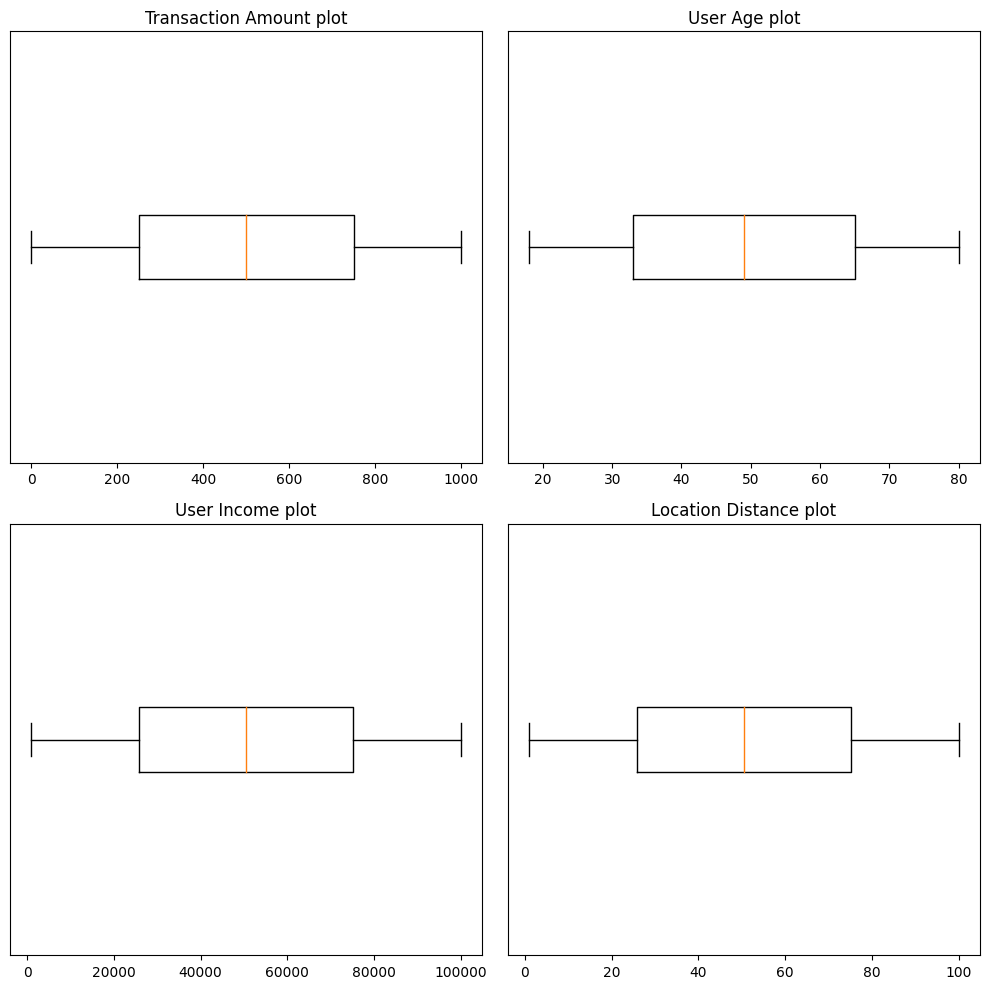

Most of the Numerical Columns are Normally Distributed


In [12]:
# checking distribution for user income, transaction income
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))

# Create horizontal boxplots by setting vert to False
ax[0, 0].boxplot(data['Transaction Amount'], vert=False)
ax[0, 1].boxplot(data['User Age'], vert=False)
ax[1, 0].boxplot(data['User Income'], vert=False)
ax[1, 1].boxplot(data['Location Distance'], vert=False)

# Set individual titles for each subplot
ax[0, 0].set_title('Transaction Amount plot')
ax[0, 1].set_title('User Age plot')
ax[1, 0].set_title('User Income plot')
ax[1, 1].set_title('Location Distance plot')

# Remove y-axis labels for the middle plots
ax[0, 1].set_yticks([])
ax[0, 0].set_yticks([])
ax[1, 0].set_yticks([])
ax[1, 1].set_yticks([])

# Adjust subplot spacing
plt.tight_layout()

# Show the plot
plt.show()
print('Most of the Numerical Columns are Normally Distributed')

In [13]:
# grouping user income into different class
num_of_bins = 3
labels =  ['Low income', 'Mid income', 'High income']
bins = pd.cut(data['User Income'], bins = num_of_bins,
                                              retbins = True, include_lowest = True)[1]

data['User Income Group'] = pd.cut(data['User Income'], bins = bins, labels = labels)
data.groupby('Fraudulent Flag')['User Income Group'].value_counts().unstack()

User Income Group,Low income,Mid income,High income
Fraudulent Flag,,,
0,967840,968568,966047
1,967039,967691,967828


In [14]:
# grouping user age into categorical class

number_of_bins = 3
labels =  ['Young', 'Mid Age', 'Old Age']
bins = pd.cut(data['User Age'], bins = num_of_bins,
                                              retbins = True, include_lowest = True)[1]

data['User Age Group'] = pd.cut(data['User Age'], bins = bins, labels = labels)
data.groupby('Fraudulent Flag')['User Age Group'].value_counts().unstack()

User Age Group,Young,Mid Age,Old Age
Fraudulent Flag,,,
0,967952,967057,967446
1,967684,966557,968317


In [15]:
data['Time Taken for Transaction'].dtype

dtype('float64')

In [16]:
# group time taken for transaction
number_of_bins = 3
labels =  ['Short time', 'Norm Time', 'Long Time']
bins = pd.cut(data['Time Taken for Transaction'], bins = num_of_bins,
                                              retbins = True, include_lowest = True)[1]

data['Time Group'] = pd.cut(data['Time Taken for Transaction'], bins = bins, labels = labels)
data.groupby('Fraudulent Flag')['Time Group'].value_counts().unstack()

Time Group,Short time,Norm Time,Long Time
Fraudulent Flag,,,
0,967829,966792,967834
1,968609,966910,967039


In [17]:
bins

array([ 0.941     , 20.66666667, 40.33333333, 60.        ])

In [18]:
# defining a function for categorizing numerical columns
def group(df, old_col, new_col, num_bins=None, labels=None):
    if labels is None:
        labels = [f'Group {i + 1}' for i in range(num_bins)]

    bins = pd.cut(df[old_col], bins=num_bins, retbins=True, include_lowest=True)[1]
    df[new_col] = pd.cut(df[old_col], bins=bins, labels=labels).astype('object')

    #return df

In [19]:
# group location column
labels = ['Short Distance', 'Long Distace']
#num_bins = 2
group(data, 'Location Distance', 'Location Distance Group', 2, labels)
data.groupby('Fraudulent Flag')['Location Distance Group'].value_counts().unstack()

Location Distance Group,Long Distace,Short Distance
Fraudulent Flag,,
0,1451434,1451021
1,1451525,1451033


In [20]:
# Time taken for transaction
labels = ['Short Time', 'Long Time']
group(data, 'Time Taken for Transaction', 'Time Take for Transaction Group', 2, labels)
data.groupby('Fraudulent Flag')['Time Take for Transaction Group'].value_counts().unstack()

Time Take for Transaction Group,Long Time,Short Time
Fraudulent Flag,,
0,1451530,1450925
1,1449974,1452584


In [21]:
# Group user credit score
labels = ['Low Score', 'Normal Score', 'High Score']
group(data, "User's Credit Score", "User's Credit Score Group", 3, labels)
data.groupby('Fraudulent Flag')["User's Credit Score Group"].value_counts().unstack()

User's Credit Score Group,High Score,Low Score,Normal Score
Fraudulent Flag,,,
0,968493,968458,965504
1,969574,968888,964096


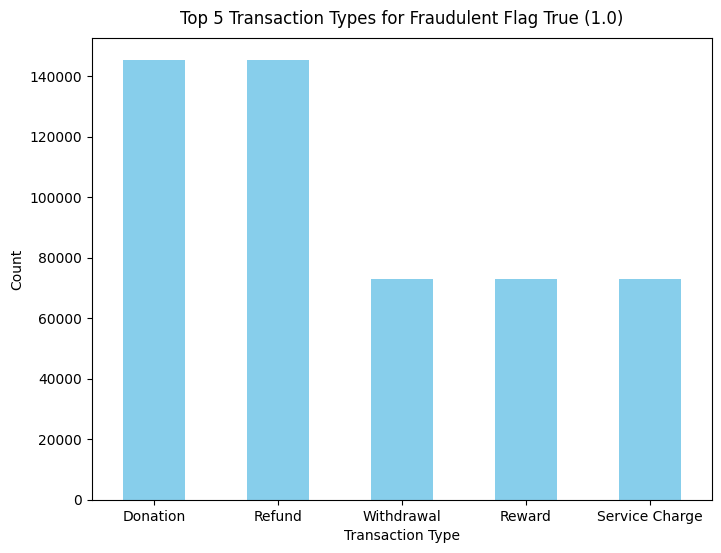

In [22]:
# understanding the top 5 transaction type that aided fraudulent activity
transaction_type = data.groupby('Fraudulent Flag')['Transaction Type'].value_counts().unstack()
transaction_type
fraudulent_flag_1 = transaction_type.loc[1.0]

sorted_data = fraudulent_flag_1.sort_values(ascending=False)

# Select the top 5 values
top_5_data = sorted_data.head(5)

# Plot the top 5 values in a bar chart
plt.figure(figsize=(8, 6))
top_5_data.plot(kind='bar', color='skyblue')
plt.xlabel('Transaction Type')
plt.ylabel('Count')
plt.title('Top 5 Transaction Types for Fraudulent Flag True (1.0)', pad= 10)
plt.xticks(rotation=0)
plt.show()# accessing all transaction type that aided fraudulent acts

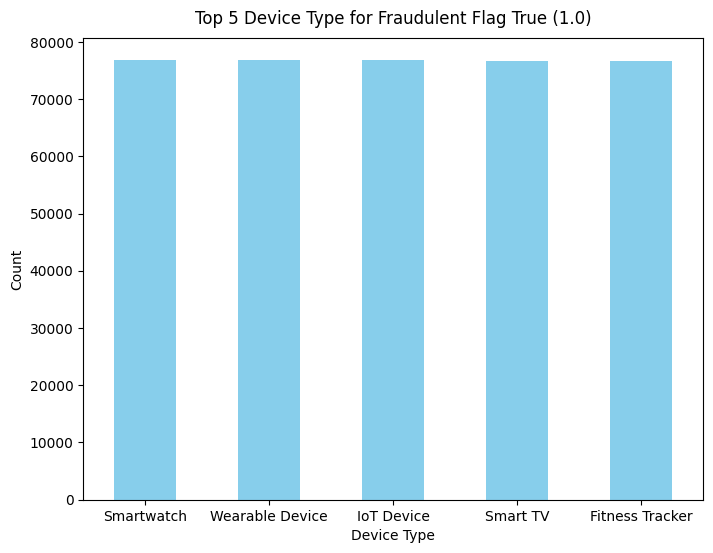

In [23]:
# understanding the top 5 Device type that aided fraudulent activity
device_type = data.groupby('Fraudulent Flag')['Device Type'].value_counts().unstack()
device_type
fraudulent_flag_1 = device_type.loc[1.0]

sorted_data = fraudulent_flag_1.sort_values(ascending=False)

# Select the top 5 values
top_5_data = sorted_data.head(5)

# Plot the top 5 values in a bar chart
plt.figure(figsize=(8, 6))
top_5_data.plot(kind='bar', color='skyblue')
plt.xlabel('Device Type')
plt.ylabel('Count')
plt.title('Top 5 Device Type for Fraudulent Flag True (1.0)', pad= 10)
plt.xticks(rotation=0)
plt.show()

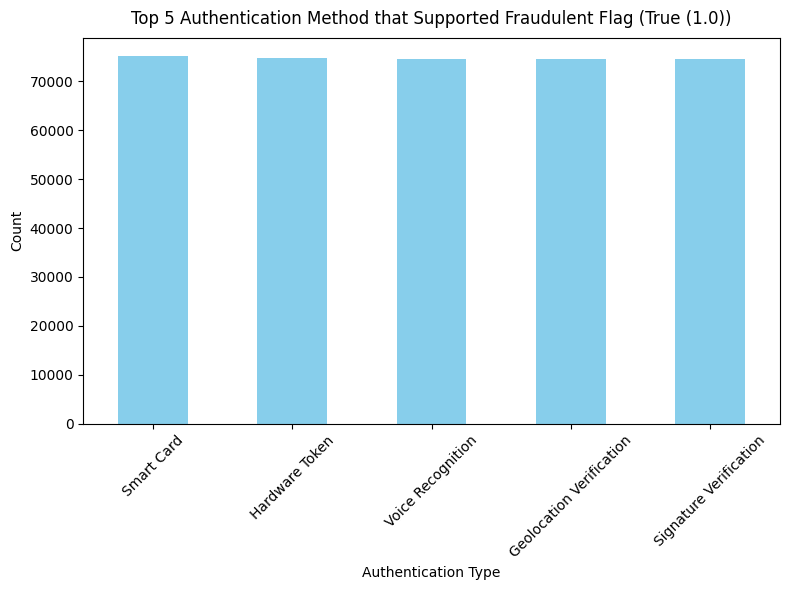

In [24]:
# understanding the top 5 authentication type that aided fraudulent activity
authentication_type = data.groupby('Fraudulent Flag')['Transaction Authentication Method'].value_counts().unstack()
authentication_type
fraudulent_flag_1 = authentication_type.loc[1.0]

sorted_data = fraudulent_flag_1.sort_values(ascending=False)

# Select the top 5 values
top_5_data = sorted_data.head(5)

# Plot the top 5 values in a bar chart
plt.figure(figsize=(8, 6))
top_5_data.plot(kind='bar', color='skyblue')
plt.xlabel('Authentication Type')
plt.ylabel('Count')
plt.title('Top 5 Authentication Method that Supported Fraudulent Flag (True (1.0))', pad= 10)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [25]:
for col in ['User Income Group', 'User Age Group', 'Time Group']:
    data[col] = data[col].astype('object')

In [26]:
data.dtypes

Transaction ID                         int64
User ID                                int64
Transaction Amount                   float64
Transaction Date and Time             object
Merchant ID                            int64
Payment Method                        object
Country Code                          object
Transaction Type                      object
Device Type                           object
IP Address                            object
Browser Type                          object
Operating System                      object
Merchant Category                     object
User Age                               int64
User Occupation                       object
User Income                          float64
User Gender                           object
User Account Status                   object
Transaction Status                    object
Location Distance                    float64
Time Taken for Transaction           float64
Transaction Time of Day               object
User's Tra

In [27]:
X = data.copy()
y = X.pop("Fraudulent Flag")

# Label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

# All discrete features should now have integer dtypes
discrete_features = X.dtypes == int

In [28]:
X.sample(5)

,Transaction ID,User ID,Transaction Amount,Transaction Date and Time,Merchant ID,Payment Method,Country Code,Transaction Type,Device Type,IP Address,Browser Type,Operating System,Merchant Category,User Age,User Occupation,User Income,User Gender,User Account Status,Transaction Status,Location Distance,Time Taken for Transaction,Transaction Time of Day,User's Transaction History,Merchant's Reputation Score,User's Device Location,Transaction Currency,Transaction Purpose,User's Credit Score,User's Email Domain,Merchant's Business Age,Transaction Authentication Method,User Income Group,User Age Group,Time Group,Location Distance Group,Time Take for Transaction Group,User's Credit Score Group
991341,95289283,6079,109.14,980089,7767,28,31,10,17,985783,17,32,29,74,15,47680.49,1,0,32,3.91,27.70,1,93,4.98,17,19,29,388,25,16,28,0,0,0,0,0,0
1373169,66060189,1512,951.07,1351588,7224,39,26,32,35,1362511,38,10,18,62,3,32998.18,4,11,5,92.62,8.95,2,62,3.80,14,24,13,763,9,16,37,2,0,2,1,0,1
5022000,45305236,8839,382.19,4740770,1451,3,20,35,10,4882096,11,22,18,21,20,62491.43,0,16,34,65.19,21.48,2,80,1.44,23,30,11,838,14,17,8,0,1,0,1,0,1
4215047,93770101,2623,936.26,4015316,1775,23,25,3,8,4116036,35,16,11,59,14,74913.87,1,15,15,87.91,36.89,1,18,2.31,3,13,22,513,13,10,24,1,2,0,1,1,2
302525,44047965,1502,962.22,201315,7240,9,15,21,37,302030,31,27,29,20,13,78839.41,2,4,38,13.57,45.21,0,90,2.44,20,24,13,500,21,19,30,1,1,1,0,1,2


In [29]:
# Droping ID columns
X = X.drop(columns =[i for i in X.columns if 'ID' in i.split()])

In [30]:
already_extracted_cols = ['Transaction Date and Time','User Income', 'User Age', 'Time Group',
          'Location Distance', 'Time Taken for Transaction', "User's Credit Score Group"]
for i in already_extracted_cols:
  X.pop(i)

X.columns


Index(['Transaction Amount', 'Payment Method', 'Country Code',
       'Transaction Type', 'Device Type', 'IP Address', 'Browser Type',
       'Operating System', 'Merchant Category', 'User Occupation',
       'User Gender', 'User Account Status', 'Transaction Status',
       'Transaction Time of Day', 'User's Transaction History',
       'Merchant's Reputation Score', 'User's Device Location',
       'Transaction Currency', 'Transaction Purpose', 'User's Credit Score',
       'User's Email Domain', 'Merchant's Business Age',
       'Transaction Authentication Method', 'User Income Group',
       'User Age Group', 'Location Distance Group',
       'Time Take for Transaction Group'],
      dtype='object')

In [31]:
print(len(X.columns), len(data.columns))

27 38


In [32]:
selected_features = ['Transaction Amount', 'User Income Group', 'Time Take for Transaction Group',
       "User's Credit Score", 'Location Distance Group',
       "Merchant's Reputation Score", "User's Device Location",
       "User's Transaction History", 'User Age Group', 'Country Code',
       'Operating System', 'Transaction Status', 'Payment Method',
       'Merchant Category', "User's Email Domain", 'Device Type']

len(selected_features)

16

In [36]:
# Train-set, Validation-set and Test-set

train_X, test_X, train_y, test_y = train_test_split(X[selected_features], y, test_size=0.2, stratify=y, random_state = 33)

train_X, val_X, train_y, val_y = train_test_split(test_X, test_y, test_size=0.25, random_state = 33)


In [42]:
print(f"Train size: {train_X.shape[0]}")
print(f"Validation size: {val_X.shape[0]}")
print(f"Test size: {test_X.shape[0]}")

Train size: 870752
Validation size: 290251
Test size: 1161003


In [37]:
# lightGBM model fit
gbm = LGBMClassifier(deterministic=True,
                     max_depth=10,
                     metric='binary_logloss',
                     n_estimators=1500,
                     num_leaves=511,
                     objective='binary',
                     learning_rate=0.065,
                     tree_learner='data',
                     force_row_wise=True,
                     min_data_in_leaf=17,
                     class_weight='balanced',
                     verbose=-1,
                     save_binary=True)

gbm.fit(train_X,
        train_y,
        eval_set=[(val_X, val_y)],
        eval_metric='auc',
        )
train_pred = gbm.predict(train_X)

print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(train_pred, train_y)))

pred = gbm.predict(test_X)
print('Test-set accuracy score: {0:0.4f}'. format(accuracy_score(pred, test_y)))

Training-set accuracy score: 0.9411
Test-set accuracy score: 0.8310


In [ ]:
# retrain the model
gbm.fit(train_X,
        train_y,
        eval_set=[(val_X, val_y)],
        eval_metric='auc',
        )

pred = gbm.predict(test_X)
print('Test-set accuracy score: {0:0.4f}'. format(accuracy_score(pred, test_y)))

In [39]:
# Save model

# Create a folder in the root directory
!mkdir -p "/content/drive/My Drive/Fraud Detection Model"

pickle.dump(gbm, open('/content/drive/My Drive/Fraud Detection Model/model.pkl', 'wb'))

In [41]:
# Load model

pickled_model = pickle.load(open('/content/drive/My Drive/Fraud Detection Model/model.pkl', 'rb'))
pickled_pred = pickled_model.predict(test_X)

# Testing
print('Test-set accuracy score: {0:0.4f}'. format(accuracy_score(pickled_pred, test_y)))